### Machine learning for NASA's IRIS satellite
#### t-Distributed Stochastic Neighbor Embedding (t-SNE)  
*by Brandon Panos*$^{1,2,3}$

1 *University of Applied Sciences and Arts Northwestern Switzerland, Bahnhofstrasse 6, 5210 Windisch, Switzerland*   
2 *University of Bern, Astronomical Institute, Sidlerstrasse 5, 3012 Bern, Switzerland*  
3 *University of Geneva, CUI-SIP, 1205 Geneva, Switzerland* 

**----------------------------------------------------------------------------------------------------------------------------**

t-SNE is a form of dimensionality reduction introduced by [L. van der Maaten and G. Hinton (2008)](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) that allows one to visualize high dimensional data at different scales. Ordinarily dimensionality reduction techniques favore the preservation of either global or local structures. t-SNE introduces a parameter called the perplexity that can be adjusted to probe the geometry of the original dataset at different granularities (from local to global).

## How the algorithm works

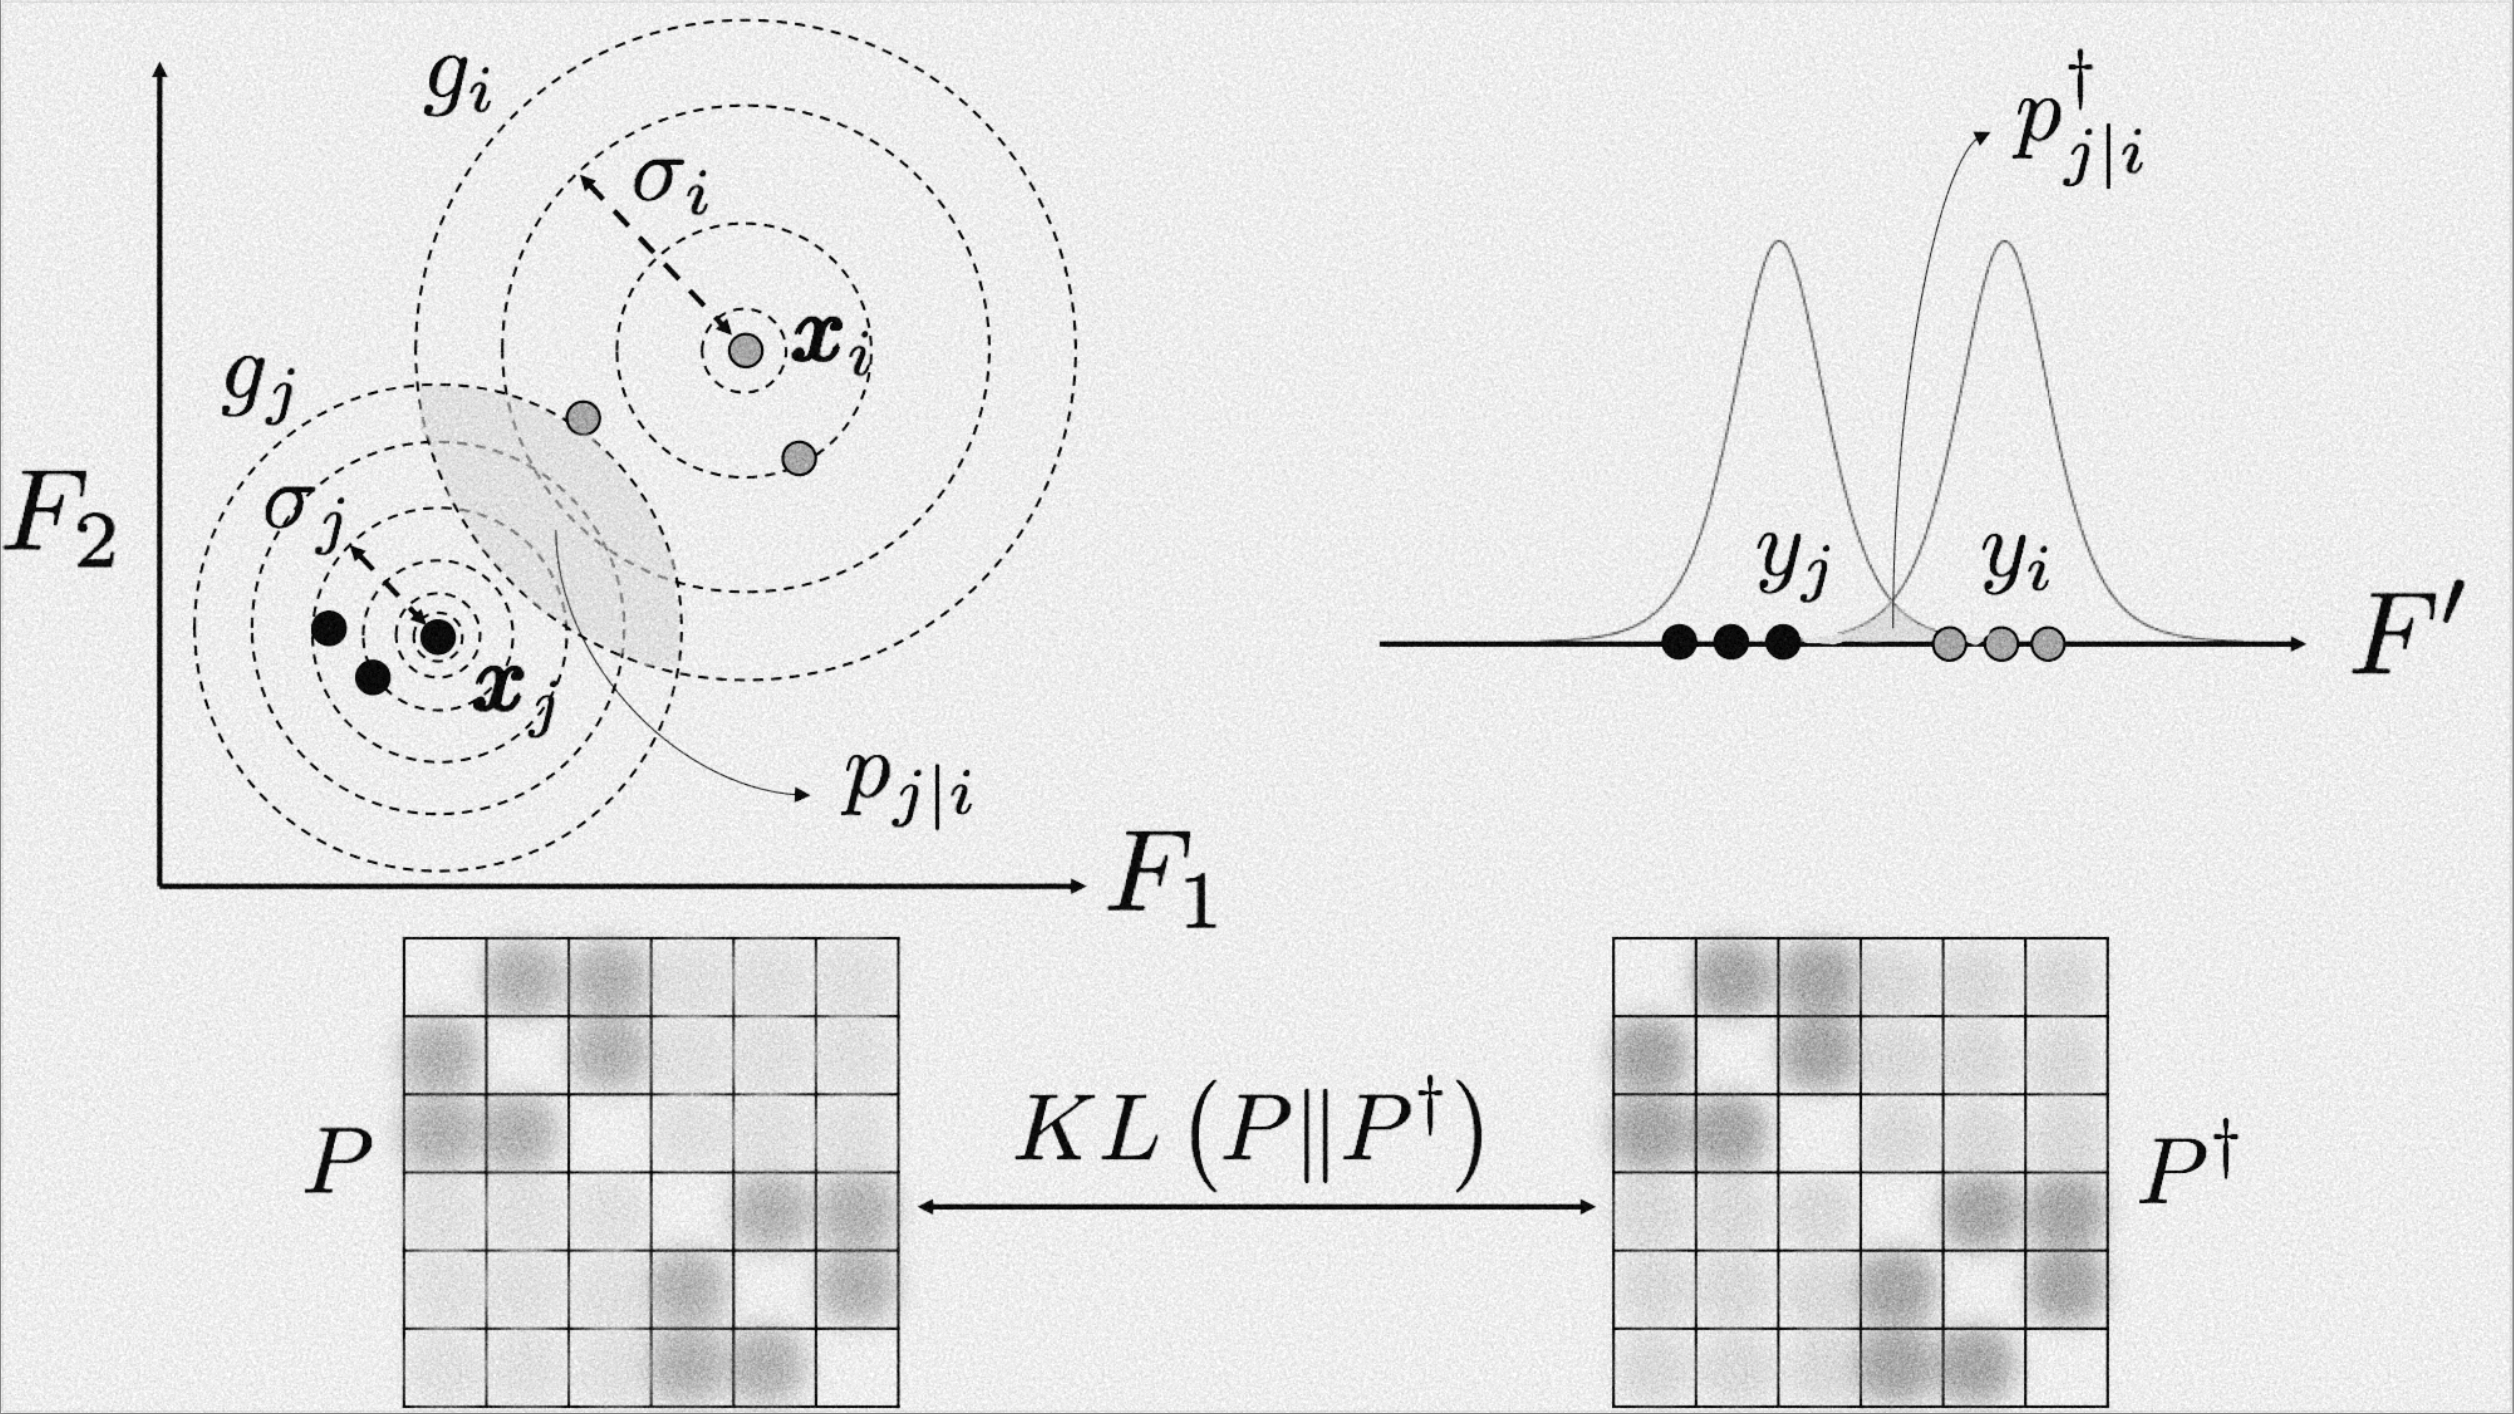

In [3]:
display.Image("pics/tsne_mathsbw.png")

The above figure shows how the t-SNE algorithm embedded points from a high dimensional space (2D left), to a low dimensional space (1D right). The geometry of a dataset is entire captured by its point-wise distance matrix $D_{i,j}$. t-SNE converts geometric euclidean distance into statistical distance by placing Gaussians above each data point in the original high dimensional space as seen in the left image of the above figure. The distance matrix documenting all the pairwise distances between points is converted into a statistical distance matrix $D\to P$, where the entries $p_{ij}$ are the degree of overlap between point $x_i$ and $x_j$'s Gausians.

$$
p_{ji}=\frac{\exp \left(-\left\|x_i-x_j\right\|^2 / 2 \sigma_i^2\right)}{\sum_{k \neq i} \exp \left(-\left\|x_i-x_k\right\|^2 / 2 \sigma_i^2\right)}
$$


What makes t-SNE special is that we can now weigh the importance of local vs global structures. This is done by allowing the Gaussians to adapt according to the datas underlying density distributions. To do this, t-SNE introduces a flexible measuring stick by requiring each points Gausian distribution to have a fixed shannon entropy

$$
S\left(g_i\right)=-\sum_j p_{ji} \log _2 p_{ji}.
$$

Depending on the local density, each point's distribution adapts its variance such that the set Shannon entropy remains fixed, leading to larger variance for $x_i$ where the density is lower, and small variance for $x_j$ where the density is higher. The entropy is encoded in a value called the perplexity $\alpha=2^{S}$ and it is the only free variable for the algorithm with a range between $1\leq\alpha\leq N$, where N is the number of samples. The smaller the perplexity, the smaller the entropy, and consequently, the set of Gausian distributions have very tight variances, implying that long range information is lost as each point is only aware of its local neighborhood. Larger perplexity implies larger entropy, which in turn results in large variance and the preservation of global structure.

As with most ML algorithms, t-SNE is variational, meaning that we start with a poor guess about the best configuration of points in 1D, and then incrementally improve our embedding. We construct a statistical distance matrix $P^\dagger$ just as we did in 2D, but instead of Gausians we use Student’s t-distributions with thicker tails to avoid overcrowding. To optimize we require both distributions to be as close to one another as possible, this is done using the KL-divergence,

$$
K L\left(P \| P^{\dagger}\right)=\sum_i \sum_j p_{i j} \log \frac{p_{i j}}{p_{i j}^{\dagger}}
$$

which is an f-divergence that measures the distance between two distributions. We then incrementally adjust the locations of the points in 1D in the direction of the fastest decrease

$$
\frac{\delta(\mathrm{KL})}{\delta y_i}=4 \sum_j\left(p_{i j}-p_{i j}^{\dagger}\right)\left(y_i-y_j\right)\left(1+\left\|y_i-y_j\right\|^2\right)^{-1}.
$$

In [2]:
# Download libraries 
import pickle # for loading data
import numpy as np # for handling matrices
from sklearn import manifold # sklearns library for t-sne
# libraries for plotting
from IPython import display
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
np.random.seed(1) # for reproducibility 

***Load data***  
We now apply t-SNE to spectral data from the Sun, specifically, each data instance is a collection of six features derived from Mg II spectra, such as line width, intensity, triplet emission and so on. We have two datasets, one contains features of spectra collected from the quiet Sun, while the other dataset contains features of spectra during a solar flare. Our goal is to examine whether these two datasets occupy distinct subspaces, i.e., are they easily speerable, and if so, which of the six features are most important for determining whether a spectra comes from the quiet Sun or a flare. 

In [1]:
# Load quiet Sun dictionary
with open('data/qs_features.p', 'rb') as f: qs_features = pickle.load(f)
# Load flare dictionary
with open('data/fl_features.p', 'rb') as f: fl_features = pickle.load(f) 
qs_features.keys()

dict_keys(['intensity', 'triplet_intensity', 'line_width', 'line_asymmetry', 'total_continium', 'kh_ratio'])

In [2]:
# t-SNE is a computationly expensive algorithm so will will create a function to randomly sample our data

def sample_spectra(features, sample_size=50000):
    '''
    input: features --> Dictionary containing the six features of each spectrum
    output: sample_features --> corresponding feature dictionary 
    ''' 
    inds = np.random.randint(features['intensity'].shape[0], size=sample_size)
    sample_features = {}
    for key, vals in features.items():
        sample_features[key] = features[key][inds]
    return sample_spectra, sample_features

In [3]:
# downsample dataset 
qs_sample_spectra, qs_sample_features = sample_spectra(qs_features, sample_size=5000)
fl_sample_spectra, fl_sample_features = sample_spectra(fl_features, sample_size=5000)

We will now join both the QS and FL datasets into one big matrix and list of features while still keeping track of which dataset each spectrum comes from 

In [4]:
def join_and_label(features1, features2):
    features = {}
    for key, vals in features1.items():
        features[key] =  np.concatenate((vals, features2[key]))
    spectra_1y = np.full((1,len(features1['intensity'])), 0)
    spectra_2y = np.full((1,len(features2['intensity'])), 1)
    spectra_y = np.concatenate((spectra_1y, spectra_2y), axis = 1)
    class_label = np.squeeze(spectra_y)
    return features, class_label

In [5]:
features, class_label  = join_and_label(fl_sample_features, qs_sample_features)

In [6]:
# We will use the sklearn implementation of t-SNE, which expects the data in the form of a matrix (i, feature)
# We therefore create a matrix where each row consists of a single spectrums six features 

feature_matrix = []
for feature, feature_vec in features.items():
    feature_matrix.append(feature_vec) 
feature_matrix = np.vstack(feature_matrix).T

We will now use the t-SNE algorithm from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to go from a high 6D representation to a 2D representation. We will also create a function that varies the perplexity such that we probe the geometry at different scales.

In [7]:
def plot_feature_map( projected_spectra ):
    # set plot styles
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 10
    # Create QS and FL masks
    FL = class_label == 0
    QS = class_label == 1
    # Create plot grid
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(2, 3, wspace=0, hspace=0)
    # Iterate over different perplexities
    perplexities = [1,2,13,20,50,150]
    for i in range(2):
        for j in range(3):
            ind = (i*3)+j
            perp = perplexities[ind] 
            # create model at current perplexity setting 
            tsne = manifold.TSNE(n_components=2, init='random', perplexity=perp, learning_rate='auto')
            projected_spectra = tsne.fit_transform(feature_matrix)
            # plot
            ax = fig.add_subplot(gs[i, j])
            plt.title('Perplexity = '+str(perp), c='k')
            plt.scatter(projected_spectra[FL, 0], projected_spectra[FL, 1], c="k", s = .1, alpha=1, label='FL spectra')  
            plt.scatter(projected_spectra[QS, 0], projected_spectra[QS, 1], c='grey', s = .1, alpha=1, label='QS spectra')
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white') 
            ax.spines['right'].set_color('white')
            ax.spines['left'].set_color('white')
            plt.xticks([])
            plt.yticks([])
    plt.style.use('default')
    return None

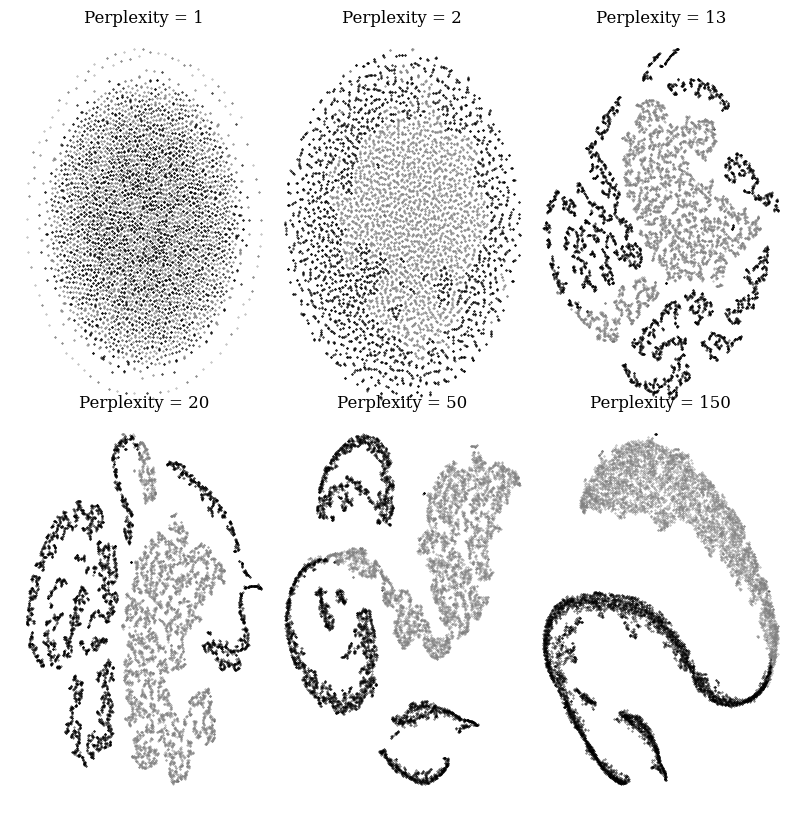

In [8]:
# Feed our matrix of features into our fucntion
ll = plot_feature_map( feature_matrix );

For perplexity = 1, we see no structure since t-SNE is only concerned with correctly representing each point and its nearest neighbor. As the perplexity increases however, we see more structure and it becomes clear that the two classes of spectra (black, grey) are easily separable, even within 2D. 

We now fix the perplexity at 150 and see which of the 6 features are the strongest predictors of each class.

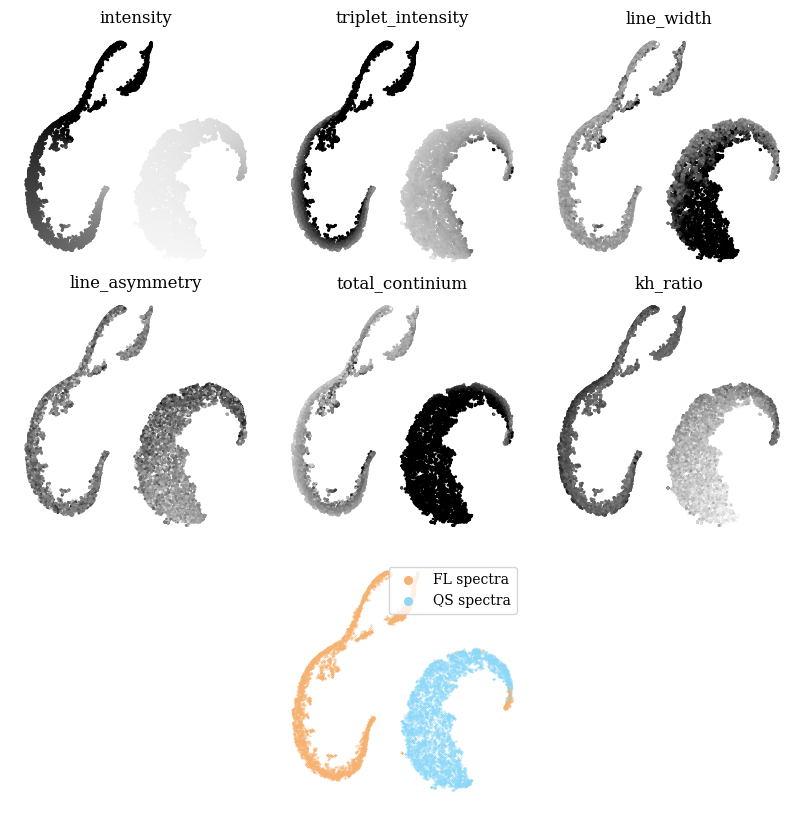

In [9]:
# create model for the selected perplexity 
tsne = manifold.TSNE(n_components=2, init='random', perplexity=150, learning_rate='auto')
projected_spectra = tsne.fit_transform( feature_matrix )

def plot_feature_map( projected_spectra, features ):
    # set plot styles
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 10
    cm = plt.cm.get_cmap('binary')
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(3, 3, wspace=.1, hspace=.1)
    vmaxmin =[[0, 600],
              [0,50],
              [3,15],
              [-0.5,0.5],
              [0,15],
              [0.85,1.3]]
    feature_list = list(features.keys()) 
    for i in range(2):
        for j in range(3):
            ind = (i*3)+j
            ax = fig.add_subplot(gs[i, j])
            plt.title(feature_list[ind], c='k', fontsize=12)
            sc = plt.scatter(projected_spectra[:, 0],projected_spectra[:, 1], 
                 c=features[feature_list[ind]], 
                             s = 1, 
                             alpha=1,
                             cmap=cm,
                             vmin=vmaxmin[ind][0], vmax=vmaxmin[ind][1])
            ax.spines['bottom'].set_color('white')
            ax.spines['top'].set_color('white') 
            ax.spines['right'].set_color('white')
            ax.spines['left'].set_color('white')
            plt.xticks([])
            plt.yticks([])
    # Create QS and FL masks
    FL = class_label == 0
    QS = class_label == 1  
    ax = fig.add_subplot(gs[2, 1])    
    plt.scatter(projected_spectra[FL, 0], projected_spectra[FL, 1], c="#f6b270", s = .1, alpha=1, label='FL spectra')  
    plt.scatter(projected_spectra[QS, 0], projected_spectra[QS, 1], c='#8dd8f8', s = .1, alpha=1, label='QS spectra')
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    lgnd = plt.legend(loc="best", numpoints=1, fontsize=10)
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white') 
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')
    plt.xticks([])
    plt.yticks([])
    plt.style.use('default')   
    return None

ll = plot_feature_map( projected_spectra, features)

t-SNE naturally separates almost all of the flare data (orange) from the quiet Sunn data (blue), meaning that spectra from these two classes have very different features from one another. Furthermore it is clear that Intensity followed by total continuum and line width are the most discriminant features, whilst features such as line asymmetry are weak class predictors.

Notice that each time we run t-SNE we find a different embedding, this is due to the stochastic nature of the optimization process. Additionally PCA, t-SNE does not establish a new coordinate system, therefore, one cannot map a new point once the algorithm has converged. The introduction of a new datapoint has the ability to organically alter the entire structure of the end result. To develop an intuition for interpreting the results of t-SNE, I suggest the excellent interactive blog of [Distill](https://distill.pub/2016/misread-tsne/). 